## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import scipy
from scipy import optimize
import pickle
import seaborn as sns

## Define functions used in the calibration

In [3]:
## Function for determining k and m in the RH Growth Correction Equation
def hygro_fit(X, Y, RH, p0=(0.5,1), print_results=True):
    p_opt, p_cov = scipy.optimize.curve_fit(lambda t,k,m: t*m/(1+k/(100/(RH)-1)),  X,  Y,  p0=p0)
    if print_results:
        print('k = ' + str(round(p_opt[0],4)) + ' ± ' + str(round(np.sqrt(np.diag(p_cov))[0],4)))
        print('m = ' + str(round(p_opt[1],4)) + ' ± ' + str(round(np.sqrt(np.diag(p_cov))[1],4)))
    return p_opt
## X is the raw data, Y is the reference data
## Returns p_opt, where p_opt[0] = k and p_opt[1] = m


## Function for fitting the k and m coefficients to a sine wave with a period set to one year
def sin_fit(X, Y, p0=(0.4, 75, 0.4), print_results=True):
    p_opt, p_cov = scipy.optimize.curve_fit(lambda t,amp, delta, offset: amp * np.sin((2*np.pi/365)*(t - delta)) + offset,  X,  Y,
                                            p0=p0, bounds=([0,0,0],[10,365,10]))
    if print_results:
        print('amp = ' + str(round(p_opt[0],4)) + ' ± ' + str(round(np.sqrt(np.diag(p_cov))[0],4)))
        print('delta = ' + str(round(p_opt[1],4)) + ' ± ' + str(round(np.sqrt(np.diag(p_cov))[1],4)))
        print('offset = ' + str(round(p_opt[2],4)) + ' ± ' + str(round(np.sqrt(np.diag(p_cov))[2],4)))
    return p_opt
## X is the raw data, Y is the reference data
## Returns p_opt, where p_opt[0] = amplitude, p_opt[1] = phase shift, and p_opt[2] = offset


## Function for generating rolling coefficients for the hygroscopic growth parameter and scaling factor, k and m
## Input df must have columns labeled 'pm2_5', 'PM_ref', and 'rh'
def rolling_coef(df, rolling_hours=24*7*4):
    data_fitted = df[['pm2_5','PM_ref','rh']].copy()
    data_fitted['k'] = '' # add columns
    data_fitted['m'] = '' # add columns
    
    for rolled_df in data_fitted.rolling(rolling_hours, min_periods=(rolling_hours-96), center=True):
        rolled_df = rolled_df.dropna()
        if len(rolled_df) >= (rolling_hours - 96):
            the_index = rolled_df.index[round(len(rolled_df)/2)]
            if the_index.hour == 12:
                X = rolled_df['pm2_5']
                Y = rolled_df['PM_ref']
                RH = rolled_df['rh']
                p_opt = hygro_fit(X, Y, RH, p0=(0.5,1), print_results=False)
                k = p_opt[0]
                m = p_opt[1]
                data_fitted.loc[the_index,'k'] = k
                data_fitted.loc[the_index,'m'] = m

    data_fitted['k'] = data_fitted['k'].replace('', np.nan)
    data_fitted['m'] = data_fitted['m'].replace('', np.nan)
    data_fitted = data_fitted.dropna()
    return data_fitted
## Returns a new dataframe with daily coefficients
## Note: the coefficients are generated on hourly data, but only one coefficient is generated for each day (using a 4 week window)
##       so the resulting data frame only has daily data

## Generates the coefficients like the function rolling_coef but takes in three sites as inputs instead
def rolling_coef_3_colocations(df1, df2, df3, rolling_hours=24*7*4):

    df1 = df1.dropna()
    df2 = df2.dropna()
    df3 = df3.dropna()
    
    data_fitted = pd.concat([df1.add_suffix('_df1'),df2.add_suffix('_df2'),df3.add_suffix('_df3')], axis=1, join='outer')
    data_fitted['k'] = '' # add columns
    data_fitted['m'] = '' # add columns
    
    for rolled_df in data_fitted.rolling(rolling_hours, min_periods=(rolling_hours-96), center=True):
        if len(rolled_df) >= (rolling_hours - 96):
            the_index = rolled_df.index[round(len(rolled_df)/2)]
            if the_index.hour == 12: #only regenerating coefficients once per day
                rolled_df_long = pd.wide_to_long(rolled_df.reset_index(), ['pm2_5','rh','PM_ref'], i='local_timestamp', j='site', sep='_', suffix='\w+')
                rolled_df_long = rolled_df_long.dropna()
                X = rolled_df_long['pm2_5']
                Y = rolled_df_long['PM_ref']
                RH = rolled_df_long['rh']
                p_opt = hygro_fit(X, Y, RH, p0=(0.5,1), print_results=False)
                k = p_opt[0]
                m = p_opt[1]
                data_fitted.loc[the_index,'k'] = k
                data_fitted.loc[the_index,'m'] = m

    data_fitted['k'] = data_fitted['k'].replace('', np.nan)
    data_fitted['m'] = data_fitted['m'].replace('', np.nan)
    data_fitted = data_fitted.dropna(subset='k')
    return data_fitted

## Pull in data

In [7]:
laney = pd.read_csv("LaneyData21_22.csv", on_bad_lines="skip",index_col=[0], parse_dates=[0])
## pm2_5 is the BEACON uncorrected PM2.5 mass concentrations
## rh is the BEACON relative humidity (%)
## PM_ref is the EPA AQS PM2.5 mass concentrations

,pm2_5,rh,PM_ref
local_timestamp,,,
2021-01-01 00:00:00,42.48317,70.809442,33.0
2021-01-01 01:00:00,42.76555,72.749597,29.0
2021-01-01 02:00:00,55.94712,72.831915,46.0
2021-01-01 03:00:00,52.23430,72.320317,41.0
2021-01-01 04:00:00,41.42553,71.672708,29.0
...,...,...,...
2022-12-31 19:00:00,0.67299,74.526028,1.0
2022-12-31 20:00:00,1.91924,73.300222,1.0
2022-12-31 21:00:00,3.39667,73.232129,3.0


## Generate and Apply Coefficients

Here we generate coefficients just using one co-location pair

In [5]:
## Generate Coefficients
laney_coef = rolling_coef(laney)

In [6]:
## Fit Coefficients to Sine Waves

## For 2021
df_21 = laney_coef[laney_coef.index.year == 2021]
params_k_21 = sin_fit(df_21.index.day_of_year, df_21['k'], p0=(0.4, 75, 0.4), print_results=False)
params_m_21 = sin_fit(df_21.index.day_of_year, df_21['m'], p0=(0.4, 75, 0.4), print_results=False)

## For 2022
df_22 = laney_coef[laney_coef.index.year == 2022]
params_k_22 = sin_fit(df_22.index.day_of_year, df_22['k'], p0=(0.4, 75, 0.4), print_results=False)
params_m_22 = sin_fit(df_22.index.day_of_year, df_22['m'], p0=(0.4, 75, 0.4), print_results=False)

In [7]:
laney_w_corrected = laney.copy()

## Generate m and k using the sine wave coefficients
laney_w_corrected.loc[laney_w_corrected.index.year == 2021, 'k'] = params_k_21[0] * np.sin((2*np.pi/365)*(laney_w_corrected[laney_w_corrected.index.year == 2021].index.day_of_year - params_k_21[1])) + params_k_21[2]
laney_w_corrected.loc[laney_w_corrected.index.year == 2022, 'k'] = params_k_22[0] * np.sin((2*np.pi/365)*(laney_w_corrected[laney_w_corrected.index.year == 2022].index.day_of_year - params_k_22[1])) + params_k_22[2]
laney_w_corrected.loc[laney_w_corrected.index.year == 2021, 'm'] = params_m_21[0] * np.sin((2*np.pi/365)*(laney_w_corrected[laney_w_corrected.index.year == 2021].index.day_of_year - params_m_21[1])) + params_m_21[2]
laney_w_corrected.loc[laney_w_corrected.index.year == 2022, 'm'] = params_m_22[0] * np.sin((2*np.pi/365)*(laney_w_corrected[laney_w_corrected.index.year == 2022].index.day_of_year - params_m_22[1])) + params_m_22[2]

## Apply m and k
laney_w_corrected['PM_corr'] = laney_w_corrected['pm2_5'] * laney_w_corrected['m'] / (1 + laney_w_corrected['k']/(100/(laney_w_corrected['rh'])-1))

In [8]:
## Apply the EPA Correction Scheme
laney_w_EPAcalibration = laney.copy()
laney_w_EPAcalibration['PM_corr'] = (0.524*laney_w_EPAcalibration['pm2_5']) - (0.0862*laney_w_EPAcalibration['rh']) + 5.75

## Pull in Speciation Data

In [8]:
comp = pd.read_csv("BayAreaSpeciation.csv", on_bad_lines='skip',index_col=[0], parse_dates=[0])
comp = comp.dropna()
## The next line gets rid of points when the PM2.5 conditions are artifically low and mess up the calculation of the fraction (only ~ 5 data points)
comp = comp[comp['PM2.5 - Local Conditions'] - comp[comp.columns[comp.columns != 'PM2.5 - Local Conditions']].sum(axis=1) >= -0.5]
comp_normed = comp.divide(comp['PM2.5 - Local Conditions'], axis=0)

In [12]:
prepped = comp_normed[['Sulfate PM2.5 LC']].dropna()
sulfate_fit = sin_fit(prepped.index.day_of_year, prepped['Sulfate PM2.5 LC'], print_results=False)
prepped = comp_normed[['EC PM2.5 LC TOR']].dropna()
EC_fit = sin_fit(prepped.index.day_of_year, prepped['EC PM2.5 LC TOR'], p0=(0.1, 300, 0.1), print_results=False)

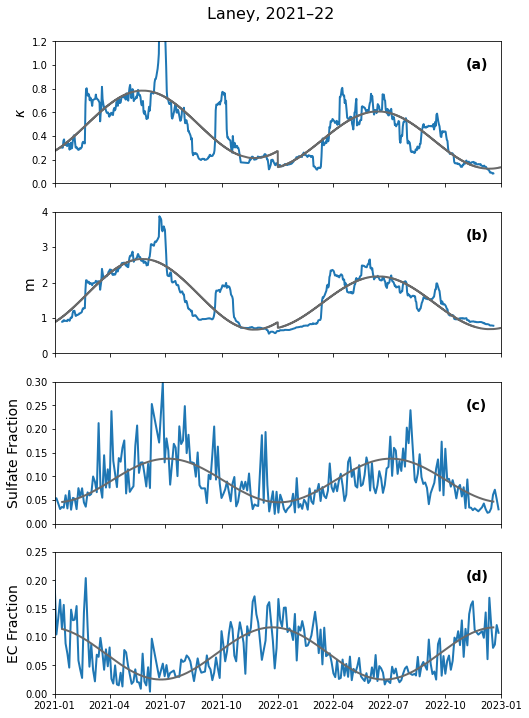

In [43]:
plt.subplots(4,1,figsize=(8,12), sharex=True)
plt.suptitle('Laney, 2021–22', fontsize=16, x=0.5, y=0.92)

plt.subplot(4,1,1)
plt.plot(laney_coef['k'], linewidth=2)
plt.plot(laney_w_corrected['k'], linewidth=2, color='dimgrey')
plt.ylim(0,1.2)
plt.ylabel('$\kappa$', fontsize=14)
plt.annotate("(a)", (datetime.datetime(2022,11,5) , 0.97), fontsize=14, fontweight='bold')

plt.subplot(4,1,2)
plt.plot(laney_coef['m'], linewidth=2)
plt.plot(laney_w_corrected['m'], linewidth=2, color='dimgrey')
plt.ylim(0,4)
plt.ylabel('m', fontsize=14)
plt.annotate("(b)", (datetime.datetime(2022,11,5) , 3.2), fontsize=14, fontweight='bold')

plt.subplot(4,1,3)
plt.plot(comp_normed[['Sulfate PM2.5 LC']] , linewidth=2)
plt.plot(laney_coef.index, sulfate_fit[0] * np.sin((2*np.pi/365)*(laney_coef.index.day_of_year - sulfate_fit[1])) + sulfate_fit[2] , linewidth=2, color='dimgrey')
plt.ylim(0,0.3)
plt.ylabel('Sulfate Fraction', fontsize=14)
plt.annotate("(c)", (datetime.datetime(2022,11,5) , 0.24), fontsize=14, fontweight='bold')

plt.subplot(4,1,4)
plt.plot(comp_normed[['EC PM2.5 LC TOR']] , linewidth=2)
plt.plot(laney_coef.index, EC_fit[0] * np.sin((2*np.pi/365)*(laney_coef.index.day_of_year - EC_fit[1])) + EC_fit[2] , linewidth=2, color='dimgrey')
plt.ylim(0,0.25)
plt.ylabel('EC Fraction', fontsize=14)
plt.annotate("(d)", (datetime.datetime(2022,11,5) , 0.20), fontsize=14, fontweight='bold')

plt.xlim(datetime.datetime(2021,1,1), datetime.datetime(2023,1,1))

# plt.savefig("/Users/milanp/Desktop/Plantower Paper/Figures/Fig 1.pdf", dpi=300, format='pdf', bbox_inches='tight')

## Residual Plots

In [22]:
laney_residuals = laney_w_corrected[['rh','PM_ref','pm2_5','PM_corr']].copy()
laney_residuals['residual'] = laney_residuals['pm2_5'] - laney_residuals['PM_ref']
laney_residuals['residual_corr'] = laney_residuals['PM_corr'] - laney_residuals['PM_ref']

In [23]:
laney_residuals_EPAcal = laney_w_EPAcalibration[['rh','PM_ref','pm2_5','PM_corr']].copy()
laney_residuals_EPAcal['residual'] = laney_residuals_EPAcal['pm2_5'] - laney_residuals_EPAcal['PM_ref']
laney_residuals_EPAcal['residual_corr'] = laney_residuals_EPAcal['PM_corr'] - laney_residuals_EPAcal['PM_ref']

In [24]:
## Here we see what happens if we didnt smooth k and m to sine waves

laney_no_smoothing = laney.copy()
laney_no_smoothing['date'] = laney_no_smoothing.index.date
laney_no_smoothing = laney_no_smoothing.reset_index()

test = laney_coef[['k','m']]
test['date'] = test.index.date

laney_no_smoothing = pd.merge(laney_no_smoothing,test, on='date', how='left').set_index('local_timestamp')
laney_no_smoothing['k'] = laney_no_smoothing['k'].interpolate(method='nearest')
laney_no_smoothing['m'] = laney_no_smoothing['m'].interpolate(method='nearest')

laney_no_smoothing['PM_corr'] = laney_no_smoothing['pm2_5'] * laney_no_smoothing['m'] / (1 + laney_no_smoothing['k']/(100/(laney_no_smoothing['rh'])-1))

laney_no_smoothing_residuals = laney_no_smoothing[['rh','PM_ref','pm2_5','PM_corr']].copy()
laney_no_smoothing_residuals['residual'] = laney_no_smoothing_residuals['pm2_5'] - laney_no_smoothing_residuals['PM_ref']
laney_no_smoothing_residuals['residual_corr'] = laney_no_smoothing_residuals['PM_corr'] - laney_no_smoothing_residuals['PM_ref']

/var/folders/nc/tks3fmrs0xv9q18_w47xnk3h0000q5/T/ipykernel_44298/642970470.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['date'] = test.index.date


''

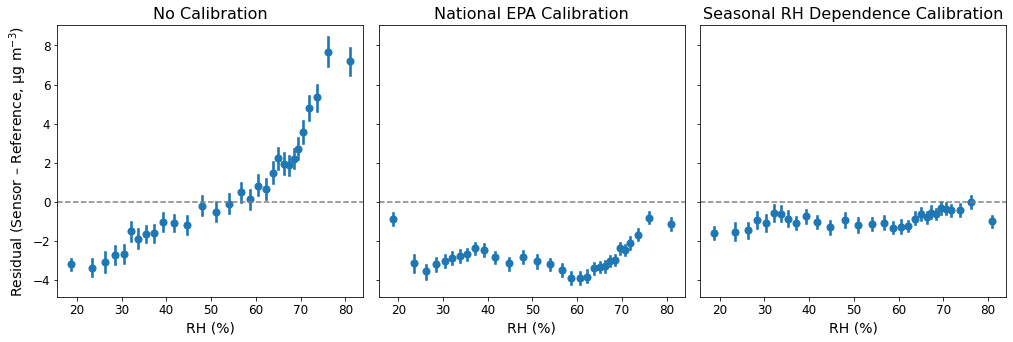

In [44]:
plt.subplots(1,3,figsize=(17,5), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05)

plt.subplot(1,3,1)
sns.regplot(data=laney_residuals, x='rh', y='residual', x_bins=30, fit_reg=False)
plt.axhline(y=0, linestyle='dashed', color='grey')
plt.ylabel('Residual (Sensor – Reference, µg m$^{-3}$)', fontsize=14)
plt.xlabel('RH (%)', fontsize=14)
plt.title('No Calibration', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(1,3,2)
sns.regplot(data=laney_residuals_EPAcal, x='rh', y='residual_corr', x_bins=30, fit_reg=False).set(ylabel=None)
plt.axhline(y=0, linestyle='dashed', color='grey')
plt.xlabel('RH (%)', fontsize=14)
plt.title('National EPA Calibration', fontsize=16)
plt.xticks(fontsize=12)

plt.subplot(1,3,3)
sns.regplot(data=laney_residuals, x='rh', y='residual_corr', x_bins=30, fit_reg=False).set(ylabel=None)
plt.axhline(y=0, linestyle='dashed', color='grey')
plt.xlabel('RH (%)', fontsize=14)
plt.title('Seasonal RH Dependence Calibration', fontsize=16)
plt.xticks(fontsize=12) 
;

In [33]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [34]:
def stats_for_figure_uncorrected(df):
    g = df[['PM_ref', 'pm2_5']].dropna()
    r = g.corr().iloc[0,1]
    r2 = g.corr().iloc[0,1]**2
    R2 = r2_score(g['PM_ref'],g['pm2_5'])
    mean_bias = np.mean(g['pm2_5'] - g['PM_ref'])
    MFB = np.mean(g['pm2_5'] - g['PM_ref'])/g['PM_ref'].mean()
    MNB = ((g['pm2_5'] - g['PM_ref']) / g['PM_ref']).replace([np.NINF, np.Inf],np.nan).mean()
    MAE = np.mean(np.abs(g['pm2_5'] - g['PM_ref']))
    rmse = np.sqrt(mean_squared_error(g['pm2_5'], g['PM_ref']))
    nrmse = np.sqrt(mean_squared_error(g['pm2_5'], g['PM_ref']))/g['PM_ref'].mean()
    IOA = 1 - ( np.sum((g['pm2_5'] - g['PM_ref'])**2) / np.sum( np.abs(g['pm2_5'] - np.mean(g['PM_ref'])) + np.abs(g['PM_ref'] - np.mean(g['pm2_5'])**2) ) )
    return {'r':round(r,3) , 'r2':round(r2,3) , 'R2':round(R2,3) , 'mean bias':round(mean_bias,3) , 'MFB':round(MFB,3) , 'MNB':round(MNB,3), 'MAE':round(MAE,3),
            'rmse':round(rmse,3) , 'nrmse':round(nrmse,3) , 'IOA':round(IOA,3) }

def stats_for_figure_corrected(df):
    g = df[['PM_ref', 'PM_corr']].dropna()
    r = g.corr().iloc[0,1]
    r2 = g.corr().iloc[0,1]**2
    R2 = r2_score(g['PM_ref'],g['PM_corr'])
    mean_bias = np.mean(g['PM_corr'] - g['PM_ref'])
    MFB = np.mean(g['PM_corr'] - g['PM_ref'])/g['PM_ref'].mean()
    MNB = ((g['PM_corr'] - g['PM_ref']) / g['PM_ref']).replace([np.NINF, np.Inf],np.nan).mean()
    MAE = np.mean(np.abs(g['PM_corr'] - g['PM_ref']))
    rmse = np.sqrt(mean_squared_error(g['PM_corr'], g['PM_ref']))
    nrmse = np.sqrt(mean_squared_error(g['PM_corr'], g['PM_ref']))/g['PM_ref'].mean()
    IOA = 1 - ( np.sum((g['PM_corr'] - g['PM_ref'])**2) / np.sum( (np.abs(g['PM_corr'] - np.mean(g['PM_ref'])) + np.abs(g['PM_ref'] - np.mean(g['PM_corr']))**2) ) )
    return {'r':round(r,3) , 'r2':round(r2,3) , 'R2':round(R2,3) , 'mean bias':round(mean_bias,3) , 'MFB':round(MFB,3) , 'MNB':round(MNB,3), 'MAE':round(MAE,3),
            'rmse':round(rmse,3) , 'nrmse':round(nrmse,3) , 'IOA':round(IOA,3) }

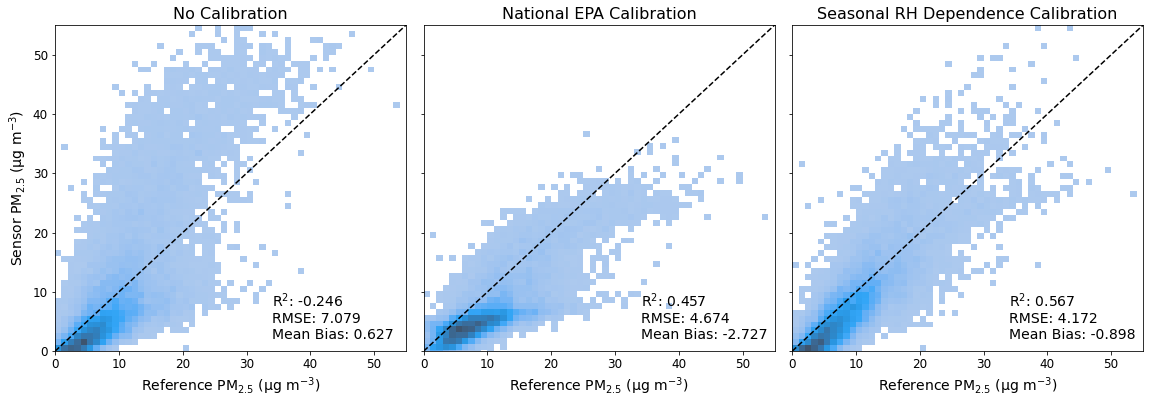

In [45]:
plt.subplots(1,3,figsize=(19.5,6), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05)

plt.subplot(1,3,1)
plt.title('No Calibration', fontsize=16)
sns.histplot(data=laney_w_corrected, x='PM_ref', y='pm2_5', binwidth=1)
plt.plot([0,60],[0,60], color='black', linestyle='dashed')
plt.xlim(0,55)
plt.ylim(0,55)
plt.xlabel('Reference PM$_{2.5}$ (µg m$^{-3}$)', fontsize=14)
plt.ylabel('Sensor PM$_{2.5}$ (µg m$^{-3}$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
stats = stats_for_figure_uncorrected(laney_w_corrected)
plt.annotate('R$^{2}$: ' + str(stats['R2']) + '\nRMSE: ' + str(stats['rmse']) + '\nMean Bias: ' + str(stats['mean bias']) , (34,2), fontsize=14)

plt.subplot(1,3,2)
plt.title('National EPA Calibration', fontsize=16)
sns.histplot(data=laney_w_EPAcalibration, x='PM_ref', y='PM_corr', binwidth=1).set(ylabel=None)
plt.plot([0,60],[0,60], color='black', linestyle='dashed')
plt.xlabel('Reference PM$_{2.5}$ (µg m$^{-3}$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
stats = stats_for_figure_corrected(laney_w_EPAcalibration)
plt.annotate('R$^{2}$: ' + str(stats['R2']) + '\nRMSE: ' + str(stats['rmse']) + '\nMean Bias: ' + str(stats['mean bias']) , (34,2), fontsize=14)

plt.subplot(1,3,3)
plt.title('Seasonal RH Dependence Calibration', fontsize=16)
sns.histplot(data=laney_w_corrected, x='PM_ref', y='PM_corr', binwidth=1).set(ylabel=None)
plt.plot([0,60],[0,60], color='black', linestyle='dashed')
plt.xlabel('Reference PM$_{2.5}$ (µg m$^{-3}$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
stats = stats_for_figure_corrected(laney_w_corrected)
plt.annotate('R$^{2}$: ' + str(stats['R2']) + '\nRMSE: ' + str(stats['rmse']) + '\nMean Bias: ' + str(stats['mean bias']) , (34,2), fontsize=14)

# plt.savefig("/Users/milanp/Desktop/Plantower Paper/Figures/Fig 4.pdf", dpi=300, format='pdf', bbox_inches='tight')

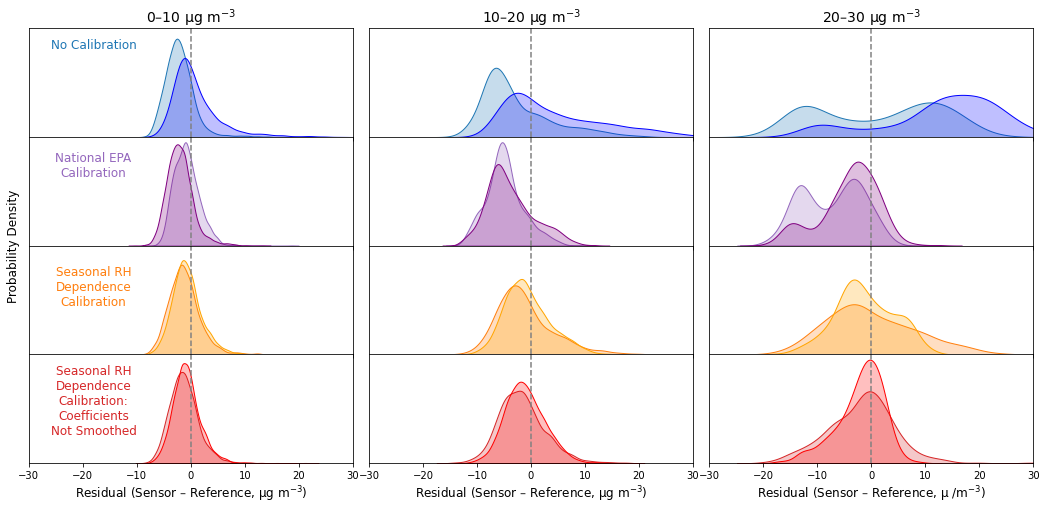

In [46]:
plt.subplots(4,3, sharex='col', sharey='col', figsize=(18,8)) #, sharey='row'
plt.subplots_adjust(wspace=0.05, hspace=0)

plt.subplot(4,3,1)
sns.kdeplot(data=laney_residuals[(laney_residuals['PM_ref'] >= 0) & (laney_residuals['PM_ref'] < 10) & (laney_residuals['rh'] < 50)], x='residual', shade=True, color='tab:blue').set(yticks=[], ylabel=None)
sns.kdeplot(data=laney_residuals[(laney_residuals['PM_ref'] >= 0) & (laney_residuals['PM_ref'] < 10) & (laney_residuals['rh'] > 50)], x='residual', shade=True, color='blue').set(yticks=[], ylabel=None)
plt.axvline(x=0, linestyle='dashed', color='grey')
plt.xlim(-30,30)
plt.title('0–10 µg m$^{-3}$', fontsize=14)

plt.subplot(4,3,2)
sns.kdeplot(data=laney_residuals[(laney_residuals['PM_ref'] >= 10) & (laney_residuals['PM_ref'] < 20) & (laney_residuals['rh'] < 50)], x='residual', shade=True, color='tab:blue').set(yticks=[], ylabel=None)
sns.kdeplot(data=laney_residuals[(laney_residuals['PM_ref'] >= 10) & (laney_residuals['PM_ref'] < 20) & (laney_residuals['rh'] > 50)], x='residual', shade=True, color='blue').set(yticks=[], ylabel=None)
plt.axvline(x=0, linestyle='dashed', color='grey')
plt.xlim(-30,30)
plt.title('10–20 µg m$^{-3}$', fontsize=14)

plt.subplot(4,3,3)
sns.kdeplot(data=laney_residuals[(laney_residuals['PM_ref'] >= 20) & (laney_residuals['PM_ref'] < 30) & (laney_residuals['rh'] < 50)], x='residual', shade=True, color='tab:blue').set(yticks=[], ylabel=None)
sns.kdeplot(data=laney_residuals[(laney_residuals['PM_ref'] >= 20) & (laney_residuals['PM_ref'] < 30) & (laney_residuals['rh'] > 50)], x='residual', shade=True, color='blue').set(yticks=[], ylabel=None)
plt.axvline(x=0, linestyle='dashed', color='grey')
plt.xlim(-30,30)
plt.title('20–30 µg m$^{-3}$', fontsize=14)

plt.subplot(4,3,4)
sns.kdeplot(data=laney_residuals_EPAcal[(laney_residuals_EPAcal['PM_ref'] >= 0) & (laney_residuals_EPAcal['PM_ref'] < 10) & (laney_residuals_EPAcal['rh'] < 50)], x='residual_corr', shade=True, color='tab:purple').set(yticks=[], ylabel=None)
sns.kdeplot(data=laney_residuals_EPAcal[(laney_residuals_EPAcal['PM_ref'] >= 0) & (laney_residuals_EPAcal['PM_ref'] < 10) & (laney_residuals_EPAcal['rh'] > 50)], x='residual_corr', shade=True, color='purple').set(yticks=[], ylabel=None)
plt.axvline(x=0, linestyle='dashed', color='grey')

plt.subplot(4,3,5)
sns.kdeplot(data=laney_residuals_EPAcal[(laney_residuals_EPAcal['PM_ref'] >= 10) & (laney_residuals_EPAcal['PM_ref'] < 20) & (laney_residuals_EPAcal['rh'] < 50)], x='residual_corr', shade=True, color='tab:purple').set(yticks=[], ylabel=None)
sns.kdeplot(data=laney_residuals_EPAcal[(laney_residuals_EPAcal['PM_ref'] >= 10) & (laney_residuals_EPAcal['PM_ref'] < 20) & (laney_residuals_EPAcal['rh'] > 50)], x='residual_corr', shade=True, color='purple').set(yticks=[], ylabel=None)
plt.axvline(x=0, linestyle='dashed', color='grey')

plt.subplot(4,3,6)
sns.kdeplot(data=laney_residuals_EPAcal[(laney_residuals_EPAcal['PM_ref'] >= 20) & (laney_residuals_EPAcal['PM_ref'] < 30) & (laney_residuals_EPAcal['rh'] < 50)], x='residual_corr', shade=True, color='tab:purple').set(yticks=[], ylabel=None)
sns.kdeplot(data=laney_residuals_EPAcal[(laney_residuals_EPAcal['PM_ref'] >= 20) & (laney_residuals_EPAcal['PM_ref'] < 30) & (laney_residuals_EPAcal['rh'] > 50)], x='residual_corr', shade=True, color='purple').set(yticks=[], ylabel=None)
plt.axvline(x=0, linestyle='dashed', color='grey')

plt.subplot(4,3,7)
sns.kdeplot(data=laney_residuals[(laney_residuals['PM_ref'] >= 0) & (laney_residuals['PM_ref'] < 10) & (laney_residuals['rh'] < 50)], x='residual_corr', shade=True, color='tab:orange').set(yticks=[], ylabel=None)
sns.kdeplot(data=laney_residuals[(laney_residuals['PM_ref'] >= 0) & (laney_residuals['PM_ref'] < 10) & (laney_residuals['rh'] > 50)], x='residual_corr', shade=True, color='orange').set(yticks=[], ylabel=None)
plt.axvline(x=0, linestyle='dashed', color='grey')
plt.xlabel('Residual (Sensor – Reference, µg m$^{-3}$)', fontsize=12)

plt.subplot(4,3,8)
sns.kdeplot(data=laney_residuals[(laney_residuals['PM_ref'] >= 10) & (laney_residuals['PM_ref'] < 20) & (laney_residuals['rh'] < 50)], x='residual_corr', shade=True, color='tab:orange').set(yticks=[], ylabel=None)
sns.kdeplot(data=laney_residuals[(laney_residuals['PM_ref'] >= 10) & (laney_residuals['PM_ref'] < 20) & (laney_residuals['rh'] > 50)], x='residual_corr', shade=True, color='orange').set(yticks=[], ylabel=None)
plt.axvline(x=0, linestyle='dashed', color='grey')
plt.xlabel('Residual (Sensor – Reference, µg m$^{-3}$)', fontsize=12)

plt.subplot(4,3,9)
sns.kdeplot(data=laney_residuals[(laney_residuals['PM_ref'] >= 20) & (laney_residuals['PM_ref'] < 30) & (laney_residuals['rh'] < 50)], x='residual_corr', shade=True, color='tab:orange').set(yticks=[], ylabel=None)
sns.kdeplot(data=laney_residuals[(laney_residuals['PM_ref'] >= 20) & (laney_residuals['PM_ref'] < 30) & (laney_residuals['rh'] > 50)], x='residual_corr', shade=True, color='orange').set(yticks=[], ylabel=None)
plt.axvline(x=0, linestyle='dashed', color='grey')
plt.xlabel('Residual (Sensor – Reference, µg m$^{-3}$)', fontsize=12)

plt.subplot(4,3,10)
sns.kdeplot(data=laney_no_smoothing_residuals[(laney_no_smoothing_residuals['PM_ref'] >= 0) & (laney_no_smoothing_residuals['PM_ref'] < 10) & (laney_no_smoothing_residuals['rh'] < 50)], x='residual_corr', shade=True, color='tab:red').set(yticks=[], ylabel=None)
sns.kdeplot(data=laney_no_smoothing_residuals[(laney_no_smoothing_residuals['PM_ref'] >= 0) & (laney_no_smoothing_residuals['PM_ref'] < 10) & (laney_no_smoothing_residuals['rh'] > 50)], x='residual_corr', shade=True, color='red').set(yticks=[], ylabel=None)
plt.axvline(x=0, linestyle='dashed', color='grey')
plt.xlabel('Residual (Sensor – Reference, µg m$^{-3}$)', fontsize=12)

plt.subplot(4,3,11)
sns.kdeplot(data=laney_no_smoothing_residuals[(laney_no_smoothing_residuals['PM_ref'] >= 10) & (laney_no_smoothing_residuals['PM_ref'] < 20) & (laney_no_smoothing_residuals['rh'] < 50)], x='residual_corr', shade=True, color='tab:red').set(yticks=[], ylabel=None)
sns.kdeplot(data=laney_no_smoothing_residuals[(laney_no_smoothing_residuals['PM_ref'] >= 10) & (laney_no_smoothing_residuals['PM_ref'] < 20) & (laney_no_smoothing_residuals['rh'] > 50)], x='residual_corr', shade=True, color='red').set(yticks=[], ylabel=None)
plt.axvline(x=0, linestyle='dashed', color='grey')
plt.xlabel('Residual (Sensor – Reference, µg m$^{-3}$)', fontsize=12)

plt.subplot(4,3,12)
sns.kdeplot(data=laney_no_smoothing_residuals[(laney_no_smoothing_residuals['PM_ref'] >= 20) & (laney_no_smoothing_residuals['PM_ref'] < 30) & (laney_no_smoothing_residuals['rh'] < 50)], x='residual_corr', shade=True, color='tab:red').set(yticks=[], ylabel=None)
sns.kdeplot(data=laney_no_smoothing_residuals[(laney_no_smoothing_residuals['PM_ref'] >= 20) & (laney_no_smoothing_residuals['PM_ref'] < 30) & (laney_no_smoothing_residuals['rh'] > 50)], x='residual_corr', shade=True, color='red').set(yticks=[], ylabel=None)
plt.axvline(x=0, linestyle='dashed', color='grey')
plt.xlabel('Residual (Sensor – Reference, µ /m$^{-3}$)', fontsize=12)

plt.text(-160, 0.22, 'Probability Density', va='center', rotation='vertical', fontsize=12)

plt.text(-144, 0.430, 'No Calibration',                                va='top', ha='center', fontsize=12, fontweight='medium', ma='center', color = 'tab:blue')
plt.text(-144, 0.315, 'National EPA\nCalibration',                     va='top', ha='center', fontsize=12, fontweight='medium', ma='center', color = 'tab:purple')
plt.text(-144, 0.200, 'Seasonal RH\nDependence\nCalibration',            va='top', ha='center', fontsize=12, fontweight='medium', ma='center', color = 'tab:orange')
plt.text(-144, 0.100, 'Seasonal RH\nDependence\nCalibration:\nCoefficients\nNot Smoothed', va='top', ha='center', fontsize=12, fontweight='medium', ma='center', color = 'tab:red')

# plt.savefig("/Users/milanp/Desktop/Plantower Paper/Figures/Fig 5.pdf", dpi=300, format='pdf', bbox_inches='tight');